# Title: Bean Sorting Demo

# Notes:

    ## Description: Jupyter notebook file for demo of machine learning with sorting beans

    ## Updated: 2022 - 03 - 23
    
    ## Author: Damon C. Roberts <damon.charles.roberts@gmail.com>

# Load relevant functions

In [1]:
# Functions for set up
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
# Functions for supervised
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Functions for unsupervised
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Functions for linear regression
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Set The Seed

In [2]:
# Set Seed
np.random.seed(1234)

# Let's make a dataset of beans and their characteristics

In [3]:
# We don't think that these variables will all be in isolation of one another (that everything is entirely random), right?
# So we need to generate a dataset that expects some amount of correlation between the variables
features, output, coef = make_regression(n_samples = 5000,
    n_features = 5, # color, size, plumpness, species, and where from
    n_informative = 4, # color, size, plumpness, and species shold all be related; but we don't think where it is from matters
    n_targets = 1, # outcome - good bean or bad bean
    noise = 1.0, # add some noise to this
    coef = True # show me the true coefficient - the population beta
    )

In [4]:

beanCharacteristics = pd.DataFrame(features, columns = ['Color', 'Size', 'Plumpness', 'Species', 'Origin']) # Make a dataframe out of the bean characteristics
# Recode the continuous data into binary data
beanCharacteristics['Good'] = output.tolist()
beanCharacteristics['Good'] = beanCharacteristics['Good'].apply(lambda x: 0 if x <= 0 else 1) # add whether the bean is good or not and coded as 1 = yes, 0 = no
beanCharacteristics['Color'] = beanCharacteristics['Color'].apply(lambda x: 0 if x <= 0 else 1) # appropriate color - 1 = yes, 0 = no
beanCharacteristics['Size'] = beanCharacteristics['Size'].apply(lambda x: 0 if x <= 0 else 1) # appropriate size - 1 = yes, 0 = no
beanCharacteristics['Plumpness'] = beanCharacteristics['Plumpness'].apply(lambda x: 0 if x <= 0 else 1) # appropriate plumpness - 1 = yes, 0 = no
beanCharacteristics['Pinto'] = beanCharacteristics['Species'].apply(lambda x: 0 if x <= 0 else 1) # pinto bean - 1 = yes, 0 = no
beanCharacteristics['Origin'] = beanCharacteristics['Origin'].apply(lambda x: 0 if x <= 0 else 1) # from a good harvester - 1 = yes, 0 = no
beanCharacteristics.head()

,Color,Size,Plumpness,Species,Origin,Good,Pinto
0,0,1,0,-0.938464,0,0,0
1,0,1,1,-1.235737,1,1,0
2,0,0,0,0.200243,0,0,1
3,1,0,1,-0.258676,1,1,0
4,1,0,1,-0.772279,0,1,0


# Supervised cook example

In [5]:
# We have a number of models we can start from. So let's choose one.
# We can start with a class called Penalized regression. Similar to OLS but has some key features.
# All of these place some sort of penalty on coefficients that are included in a model but add little value to it.
# It helps in cases where we are concerned about the variance-bias tradeoff, multicollinearity, sparse data, or aren't sure what variables to include
# There are three models we can choose from
# 1. Ridge Regression - Shrinks variables toward zero but not to it; will not eliminate useless variables
# 2. LASSO Regression - Shrinks variables to zero; will eliminate useless variables
# 3. ElasticNet Regression - Kind of a compromise between Ridge and LASSO
# Let's go with a LASSO Regression - will come up later when we run our structural model to ask our causal question
# First we need to randomly split up our bag of beans into one where we give it a first go at sorting given the chef's criteria and the last pile we will use once we know what the chef wants
beanCharacteristicsSupervised = beanCharacteristics.drop(['Good'], axis = 1)
beanGood = beanCharacteristics['Good']
xTrain, xTest, yTrain, yTest = train_test_split(beanCharacteristicsSupervised,
                                                beanGood,
                                                test_size = 0.25,
                                                random_state = 1234)
# Now say we then treat these data as being a ``population" where we haven't sorted all of the beans into good or bad piles. So we are going to all our test set as missing, as if it is missing. 
# We normally wouldn't do this step, but this is to help us simulate the normal process of supervised models
yTest = yTest.replace(np.NaN)


So what we basically have now is that we the Chef, have manually gone through and have determined that about 25% of the sample of beans is either good or bad. This is our training set. 

We have a testing set where the other 75% of the beans have not been determined as good or not. We then ask our cook to look at the good and bad bean pile and figure out how to sort the other 75% of the beans as either good or bad based on seeing what the chef had done with the first 25%

In [6]:
# Now we are going to train our model
# Using the analogy, we are going to take that 25% of beans and look at their qualities and learn about them
lassoModel = Lasso().fit(xTrain, yTrain)

In [7]:
# Given that we know about their qualities and have an idea of whether they are good or bad, we are going to try to predict the rest of them
trainingPrediction =  lassoModel.predict(xTrain)


In [8]:
# Now the chef is going to come over once we have finished sorting all of the beans
# They know what a good bean is and what a bad bean is.
# They are going to look through and see whether we were right with our sorting
# They are going to consider both whether we have some sort of bias (whether we are close to the right sorting or not) and whether it is efficient (so if we are wrong in a whole bunch of different ways)
rmse = np.sqrt(mean_squared_error(yTrain, trainingPrediction))
print(rmse, '... Okay not too great. We want it close to 0... but for the sake of simplicity, we will just go for it and sort the rest') 

0.4999839997439918 ... Okay not too great. We want it close to 0... but for the sake of simplicity, we will just go for it and sort the rest


In [9]:
# We got their permission to sort the rest of the beans. So we do it.
beanPredictions = lassoModel.predict(xTest)
# How off are we overall?
rmse = np.sqrt(mean_squared_error(yTest, beanPredictions))
print(rmse, '... we did a pretty similar job to what we did in our first go around. So cool. We are making our pot of beans')

0.49986238106102765 ... we did a pretty similar job to what we did in our first go around. So cool. We are making our pot of beans


# Unsupervised cook example

In [10]:
# Now say the cook isn't going to tell us what constitutes a good or bad bean. He just wants us to organize them based on different characteristics
# Say he tells us to just put them in three different piles
# So you do.
km = KMeans(n_clusters = 3)
km.fit(beanCharacteristics)
km.predict(beanCharacteristics)
labels = km.labels_

<ipython-input-11-3a27ea2564af>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c = labels.astype(np.float), edgecolor = 'k', s = 50)


Text(0.5, 0.92, 'K Means Clustering of Beans')

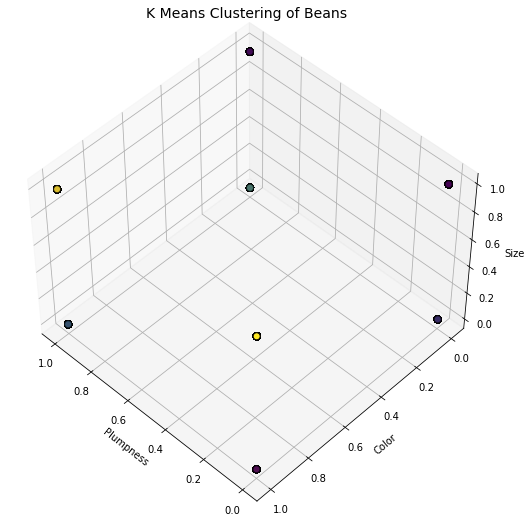

In [11]:
# And this is what our table looks like
fig = plt.figure(1, figsize = (7,7))
ax = Axes3D(fig, rect=[0,0,0.95,1], elev = 48, azim = 134)
ax.scatter(beanCharacteristics.iloc[:, 2], beanCharacteristics.iloc[:, 0], beanCharacteristics.iloc[:, 1],
c = labels.astype(np.float), edgecolor = 'k', s = 50)
ax.set_xlabel('Plumpness')
ax.set_ylabel('Color')
ax.set_zlabel('Size')
plt.title('K Means Clustering of Beans', fontsize = 14)

As we can see, we had a really hard time following the chef's instructions because we have different species of beans. Each of those species have different characteristics that are normal or not so normal for that species of bean. So we instead had to make a few more piles. So then the Chef decides, okay, you are right. Grabs the different piles, goes to their office and figures out which of each of these piles are the best for each of the species of bean.

# Structural Model - Asking the causal question

What bean characteristic is important for determining whether that bean will be yummy or not?

Let's run a regression. First, we think that size will be the best. So we expect that the underlying process for nature to determine a good bean is:

$ y_i = \alpha_i + \beta Size + \epsilon $

In [12]:
beanCharacteristics = beanCharacteristics.dropna()

simple = smf.ols(formula = 'Good ~ Size', data = beanCharacteristics).fit()
print(simple.summary())

                            OLS Regression Results                            
Dep. Variable:                   Good   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     133.4
Date:                Fri, 25 Mar 2022   Prob (F-statistic):           1.78e-30
Time:                        07:25:52   Log-Likelihood:                -3562.5
No. Observations:                5000   AIC:                             7129.
Df Residuals:                    4998   BIC:                             7142.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4273      0.010     43.329      0.0

It looks like the bean size does matter for taste!

Now say we want to expand our regression because we think other factors might matter for determining a good tasting bean and we also think that other factors work with size to influence the taste (e.g. size, color, plumpness, and origin):

$y_i = \alpha_i + \beta_{1i} Size + \beta_{2i} Color + \beta_{3i} Plumpness + \beta_{4i} Origin + \epsilon_i$

In [13]:
multivariate = smf.ols(formula = 'Good ~ Size + Color + Plumpness + Origin', data = beanCharacteristics).fit()
print(multivariate.summary())

                            OLS Regression Results                            
Dep. Variable:                   Good   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     1125.
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        07:25:52   Log-Likelihood:                -2022.1
No. Observations:                5000   AIC:                             4054.
Df Residuals:                    4995   BIC:                             4087.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0410      0.011     -3.596      0.0

It looks like everything but Plumpness have non-zero effects on whether the bean tastes good. Cool! So now we now, that when sorting our beans for taste, we should look at these particular factors to help us sort. The beans.